In [103]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.preprocessing import MinMaxScaler
from torchinfo import summary

from ignite.engine import *
from ignite.handlers import *
from ignite.metrics import *
from ignite.utils import *
from ignite.contrib.metrics.regression import *
from ignite.contrib.metrics import *

## scale data

In [104]:
seq_len = 128
input_size = 3
train_size = 950
test_size = 200
test_minisize = 50
output_size = 2
hidden_size_1 = 50
hidden_size_2 = 70
epoch_num = 500
batch = 32
learning_rate = 0.001

In [105]:
"""
f = open("./Dataset/myData/person007.csv")
f_o = open("./Dataset/myData/person_007.csv", "w")

line = f.readline()
while line:
    f_o.writelines([line[:-7], "\n"])
    line = f.readline()

f.close()
f_o.close()
"""

'\nf = open("./Dataset/myData/person007.csv")\nf_o = open("./Dataset/myData/person_007.csv", "w")\n\nline = f.readline()\nwhile line:\n    f_o.writelines([line[:-7], "\n"])\n    line = f.readline()\n\nf.close()\nf_o.close()\n'

In [106]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
path = "./Dataset/myData/"
mmscaler = MinMaxScaler(feature_range=(-1, 1), copy=True)

#training set
# amaya_data = np.loadtxt(path + "amaya0701_out.csv", delimiter=",", skiprows=100)
# kikuzo_data = np.loadtxt(path + "kikuzo0701_out.csv", delimiter=",", skiprows=100)
# rinto_data = np.loadtxt(path + "rinto0701_out.csv", delimiter=",", skiprows=100)
person000 = np.loadtxt(path + "person_000.csv", delimiter=",", skiprows=50)
person001 = np.loadtxt(path + "person_001.csv", delimiter=",", skiprows=50)
person002 = np.loadtxt(path + "person_002.csv", delimiter=",", skiprows=50)
person003 = np.loadtxt(path + "person_003.csv", delimiter=",", skiprows=50)
person004 = np.loadtxt(path + "person_004.csv", delimiter=",", skiprows=50)
person005 = np.loadtxt(path + "person_005.csv", delimiter=",", skiprows=50)
person006 = np.loadtxt(path + "person_006.csv", delimiter=",", skiprows=50)
person007 = np.loadtxt(path + "person_007.csv", delimiter=",", skiprows=50)

d_000 = person000[:,1:4]
d_001 = person001[:,1:4]
d_002 = person002[:,1:4]
d_003 = person003[:,1:4]
d_004 = person004[:,1:4]
d_005 = person005[:,1:4]
d_006 = person006[:,1:4]
d_007 = person007[:,1:4]

print(d_000.shape)
print(d_001.shape)
print(d_002.shape)
print(d_003.shape)
print(d_004.shape)
print(d_005.shape)
print(d_006.shape)
print(d_007.shape)

data_000 = np.ones((int(len(d_000)/seq_len), seq_len, input_size), float)
data_001 = np.ones((int(len(d_001)/seq_len), seq_len, input_size), float)
data_002 = np.ones((int(len(d_002)/seq_len), seq_len, input_size), float)
data_003 = np.ones((int(len(d_003)/seq_len), seq_len, input_size), float)
data_004 = np.ones((int(len(d_004)/seq_len), seq_len, input_size), float)
data_005 = np.ones((int(len(d_005)/seq_len), seq_len, input_size), float)
data_006 = np.ones((int(len(d_006)/seq_len), seq_len, input_size), float)
data_007 = np.ones((int(len(d_007)/seq_len), seq_len, input_size), float)

for i in range(int(len(d_000)/seq_len)):
    data_000[i,:,:] = d_000[i*seq_len:(i+1)*seq_len,:]
for i in range(int(len(d_001)/seq_len)):
    data_001[i,:,:] = d_001[i*seq_len:(i+1)*seq_len,:]
for i in range(int(len(d_002)/seq_len)):
    data_002[i,:,:] = d_002[i*seq_len:(i+1)*seq_len,:]
for i in range(int(len(d_003)/seq_len)):
    data_003[i,:,:] = d_003[i*seq_len:(i+1)*seq_len,:]
for i in range(int(len(d_004)/seq_len)):
    data_004[i,:,:] = d_004[i*seq_len:(i+1)*seq_len,:]
for i in range(int(len(d_005)/seq_len)):
    data_005[i,:,:] = d_005[i*seq_len:(i+1)*seq_len,:]
for i in range(int(len(d_006)/seq_len)):
    data_006[i,:,:] = d_006[i*seq_len:(i+1)*seq_len,:]
for i in range(int(len(d_007)/seq_len)):
    data_007[i,:,:] = d_007[i*seq_len:(i+1)*seq_len,:]

    
print(data_000.shape)
print(data_001.shape)
print(data_002.shape)
print(data_003.shape)
print(data_004.shape)
print(data_005.shape)
print(data_006.shape)
print(data_007.shape)



(65321, 3)
(58684, 3)
(65296, 3)
(12201, 3)
(18690, 3)
(18956, 3)
(15551, 3)
(19113, 3)
(510, 128, 3)
(458, 128, 3)
(510, 128, 3)
(95, 128, 3)
(146, 128, 3)
(148, 128, 3)
(121, 128, 3)
(149, 128, 3)


In [107]:
train000 = data_000[:100]
train001 = data_001[:350]
train002 = data_002[:100]
train003 = data_003[:100]
train004 = data_004[:100]
train005 = data_005[:100]
train006 = data_006[:100]
train007 = data_007[:100]

trX = np.vstack([train001, train000])
trX = np.vstack([trX, train002])
trX = np.vstack([trX, train003])
trX = np.vstack([trX, train004])
trX = np.vstack([trX, train005])
trX = np.vstack([trX, train006])
print(trX.shape)

test001 = data_001[350:450]
test006 = data_006[:100]
test007 = data_007[:100]

teX = np.vstack([test001, test007])
print(teX.shape)

trY = np.zeros(train_size, int)
trY[350:950] = np.ones(600, int)
print(trY.shape)

teY = np.zeros(test_size, int)
teY[100:200] = np.ones(100,int)
print(teY.shape)

(945, 128, 3)
(200, 128, 3)
(950,)
(200,)


In [108]:
trainX = torch.Tensor(np.array(trX)).to(device)
trainY = torch.Tensor(np.array(trY)).to(device)

testX = torch.Tensor(np.array(teX)).to(device)
testY = torch.Tensor(np.array(teY)).to(device)

print('trainX.shape:{0}'.format(trainX.shape))
print('trainY.shape:{0}'.format(trainY.shape))
print('testX.shape:{0}'.format(testX.shape))
print('testY.shape:{0}'.format(testY.shape))

# trainYをone-hotにするためlongにsuru
trainY = trainY.long()
# one-hotにする 
trainY = F.one_hot(trainY, num_classes=output_size)
# 誤差を計算できるようにfloatに直す
trainY = trainY.float()
# trY one-hotにする
trY = trainY.cpu().data.numpy()

#testY one-hot ni sinai!
print('trainY.shape:{0}'.format(trainY.shape))
print('trainY: {0}'.format(trainY))
print('testY: {0}'.format(testY))

trainX.shape:torch.Size([945, 128, 3])
trainY.shape:torch.Size([950])
testX.shape:torch.Size([200, 128, 3])
testY.shape:torch.Size([200])
trainY.shape:torch.Size([950, 2])
trainY: tensor([[1., 0.],
        [1., 0.],
        [1., 0.],
        ...,
        [0., 1.],
        [0., 1.],
        [0., 1.]], device='cuda:0')
testY: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1.

## Dataset Dataloader

In [109]:
class DataSet:
    def __init__(self):
        self.X = trX.astype(np.float32) # 入力
        self.t = trY # 出力

    def __len__(self):
        return len(self.X) # データ数(10)を返す

    def __getitem__(self, index):
        # index番目の入出力ペアを返す
        return self.X[index], self.t[index]

In [110]:
# さっき作ったDataSetクラスのインスタンスを作成
dataset = DataSet()
# datasetをDataLoaderの引数とすることでミニバッチを作成．
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch, \
                                         shuffle=True, drop_last=True)

## Model

In [111]:
class MyLSTM(nn.Module):
    def __init__(self):
        super().__init__()
        self.input_size = input_size
        self.hidden_size_1 = hidden_size_1
        self.hidden_size_2 = hidden_size_2
        self.cnn = CNN()
        self.lstm_1 = nn.LSTM(input_size=self.input_size, hidden_size=self.hidden_size_1, \
                              num_layers=1, batch_first=True) 
        self.lstm_2 = nn.LSTM(input_size=self.hidden_size_1, hidden_size=self.hidden_size_2, \
                             num_layers=1, batch_first=True) 
        self.relu = nn.ReLU()
        #self.linear = nn.Linear(self.hidden_size_1, output_size)
        self.linear = nn.Linear(self.hidden_size_2, output_size)
        #self.softmax = nn.Softmax(-1)

    def forward(self, x):
        # self.cnn(x)
        h_0 = torch.zeros(1, x.size(0), self.hidden_size_1).to(device)
        c_0 = torch.zeros(1, x.size(0), self.hidden_size_1).to(device)
        h_1 = torch.zeros(1, x.size(0), self.hidden_size_2).to(device)
        c_1 = torch.zeros(1, x.size(0), self.hidden_size_2).to(device)
        out, (h_out, c_out) = self.lstm_1(x, (h_0, c_0))
        _, (h_out, _) = self.lstm_2(out, (h_1, c_1))
        #h_out = h_out.view(-1, self.hidden_size_1)
        h_out = h_out.view(-1, self.hidden_size_2)
        h_out = self.relu(h_out)
        y_hat = self.linear(h_out)
        #y_hat = self.softmax(h_out)
        return y_hat

class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.input_size = input_size
        # cnn
        
        self.relu = nn.ReLU()
        

    def forward(self, x):
        
        # cnn
        h_out = self.relu(h_out)
        
        
        return y_hat

In [112]:
def train(model, optimizer, X, t):
  model.train()
  y_hat = model(X)
  # print(y_hat.shape)
  # loss = F.mse_loss(y_hat, trainY)
  loss = nn.CrossEntropyLoss()
  output = loss(y_hat, t)
  optimizer.zero_grad()
  output.backward()
  optimizer.step()
  return output.item()

loss = []


def main():
  model = MyLSTM()
  optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
  model = model.to(device)
  for epoch in range(epoch_num):
    for X, t in dataloader:
      _loss = train(model, optimizer, X.to(device), t.to(device))
      loss.append(_loss)
    if epoch % 20 == 0:
      print(f"Epoch = {epoch+1}, Loss = {_loss:.5f}")
  return model

In [113]:
def eval_step(engine, batch):
    return batch

default_evaluator = Engine(eval_step)

# create default optimizer for doctests

param_tensor = torch.zeros([1], requires_grad=True)
default_optimizer = torch.optim.SGD([param_tensor], lr=learning_rate)

# create default trainer for doctests
# as handlers could be attached to the trainer,
# each test must define his own trainer using `.. testsetup:`

def get_default_trainer():

    def train_step(engine, batch):
        return batch

    return Engine(train_step)

# create default model for doctests

# default_model = nn.Sequential(OrderedDict([
#     ('base', nn.Linear(4, 2)),
#     ('fc', nn.Linear(2, 1))
# ]))

# manual_seed(666)

In [114]:
def predict(model):
  model.eval()
  train_predict = model(testX)
  print(train_predict.shape)
  
  data_predict = torch.argmax(train_predict, dim=1)
  data_predict = F.one_hot(data_predict, num_classes=output_size)
  
  metric = ConfusionMatrix(num_classes=output_size)
  metric.attach(default_evaluator, 'cm')
  y_true = testY.int()
  y_pred = data_predict
  print(y_true.shape)
  print(y_pred.shape)

  state = default_evaluator.run([[y_pred, y_true]])
  print(state.metrics['cm'])


In [115]:
model = main()

Epoch = 1, Loss = 0.69622
Epoch = 21, Loss = 0.67152
Epoch = 41, Loss = 0.60541
Epoch = 61, Loss = 0.71150
Epoch = 81, Loss = 0.58716
Epoch = 101, Loss = 0.69970
Epoch = 121, Loss = 0.68746
Epoch = 141, Loss = 0.58151
Epoch = 161, Loss = 0.60981
Epoch = 181, Loss = 0.59752
Epoch = 201, Loss = 0.60811
Epoch = 221, Loss = 0.58593
Epoch = 241, Loss = 0.50315
Epoch = 261, Loss = 0.52121
Epoch = 281, Loss = 0.46597
Epoch = 301, Loss = 0.35339
Epoch = 321, Loss = 0.25588
Epoch = 341, Loss = 0.24819
Epoch = 361, Loss = 0.25497
Epoch = 381, Loss = 1.05851
Epoch = 401, Loss = 0.38083
Epoch = 421, Loss = 0.72754
Epoch = 441, Loss = 0.19758
Epoch = 461, Loss = 0.18859
Epoch = 481, Loss = 0.14683


In [116]:
predict(model)

torch.Size([200, 2])
torch.Size([200])
torch.Size([200, 2])
tensor([[ 98,   2],
        [  0, 100]])


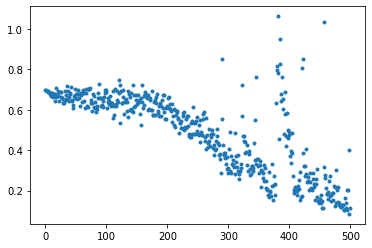

In [117]:
stop = len(loss)
step = int(len(loss) / epoch_num)
plt.plot(loss[0:stop:step], '.', label = "test_error")
plt.show()